## Creating a Baseline

This script will walk you through the creating of a baseline model for the data.

In [2]:
import numpy as np
import importlib
import fncs
import matplotlib.pyplot as plt
import random

importlib.reload(fncs)

<module 'fncs' from '/voc/work/fncs.py'>

### Loading the Data and Features

First, we define a helper function to load the data and compute the features. Take a look at how the labels are extracted by following a similar procedure for window extraction and assigning the mode.

In [4]:
# It loads the data and extracts the features
def loadFeatures(dataFolder,winSz,timeStep,idList):
    for k,id in enumerate(idList):
        # Loading the raw data
        xt, xv, yt, yv = fncs.loadTrial(dataFolder,id=id)

        # Extracting the time window for which we have values for the measurements and the response
        timeStart = np.max((np.min(xt),np.min(yt)))
        timeEnd = np.min((np.max(xt),np.max(yt)))

        # Extracting the features
        _, feat = fncs.extractFeat(xt,xv,winSz,timeStart,timeEnd,timeStep)
        _, lab = fncs.extractLabel(yt,yv,winSz,timeStart,timeEnd,timeStep)

        # Storing the features
        if(k==0):
            featList = feat
            labList = lab
        else:
            featList = np.concatenate((featList,feat),axis=0)
            labList = np.concatenate((labList,lab),axis=0)

    return featList, labList

Extracting the features for the training data and splitting it into training / validation.

In [5]:
# Specifying the data directory
dirTrain = '../data/train/'

# Specifying some parameters for the feature extraction
timeStep = 1
winSz = 2

# Specifying IDs for training and validation sets
valIDs = [2,11,25]
trainIDs = list(set(np.array(range(29))+1).difference(valIDs))

# Recovering the features and labels
xTrain, yTrain = loadFeatures(dirTrain,winSz,timeStep,trainIDs)
xVal, yVal = loadFeatures(dirTrain,winSz,timeStep,valIDs)

In [6]:
yTrain[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Training an RF Classifier

An RF will be one of the models that we will consider as a baseline. Let us begin by defining some helper functions.

In [7]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# This function produces a summary of performance metrics including a confusion matrix
def summaryPerf(yTrain,yTrainHat,y,yHat):
    # Plotting confusion matrix for the non-training set:
    cm = metrics.confusion_matrix(y,yHat,normalize='true')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=
                                  ['Walk Hard','Down Stairs','Up Stairs','Walk Soft'])
    disp.plot()

    # Displaying metrics for training and non-training sets
    print('Training:  Acc = {:4.3f}'.format(metrics.accuracy_score(yTrain,yTrainHat)))
    print('Non-Train: Acc = {:4.3f}'.format(metrics.accuracy_score(y,yHat)))
    print('Training:  BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(yTrain,yTrainHat)))
    print('Non-Train: BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(y,yHat)))

Defining and training the model.

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Defining the model using default parameters
M_RF = RandomForestClassifier()

# Training the model
M_RF.fit(xTrain,yTrain)

RandomForestClassifier()

Performance of predictions using the training and validation set.

Results for Validation:

Training:  Acc = 1.000
Non-Train: Acc = 0.849
Training:  BalAcc = 1.000
Non-Train: BalAcc = 0.777


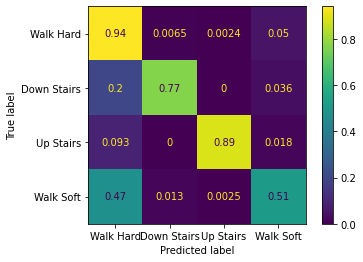

In [9]:
yTrainHat = M_RF.predict(xTrain)
yValHat = M_RF.predict(xVal)

print('Results for Validation:\n')
summaryPerf(yTrain,yTrainHat,yVal,yValHat)

### Training MLPs

Our main objective will be to do some optimization on the architecture. Let us begin by defining some helper functions.

In [10]:
import torch
import torch.nn as nn

# Creating a wrapper so we have the same interface for all the methods. This wrapper takes as an
# input an mlp model so we can reuse it with different model architectures.
class NetWrapper:
  def __init__(self,model,device,epochs,weights):
    self.model = model
    self.loss_fn = nn.CrossEntropyLoss(weight = torch.tensor(weights))
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
    self.device = device
    self.epochs = epochs

  def fit(self,X,y):
    X = torch.from_numpy(X).float()
    X = X.to(self.device)
    y = torch.from_numpy(y).long()
    y = y.to(self.device)

    for t in range(self.epochs):
      pred = self.model(X)
      loss = self.loss_fn(pred, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      if t%1000 == 999:
        print("[Epoch {t:5d} of {epochs}] loss: {loss:1.6f}".format(
            t=t+1,epochs=self.epochs,loss=loss))

  def predict(self,X):
    X = torch.from_numpy(X).float()
    X = X.to(self.device)

    pred = self.model(X)
    pred = pred.cpu().detach().numpy()
    pred = np.argmax(pred,axis=1)

    return pred
  
# Defining the input and output size of the model
INPUTSIZE = 12
OUTPUTSIZE = 4

# Specify the device that you will use here. You can change redefine this variable if needed (e.g.,
# when using Colab and wanting to use the GPUs).
DEVICE = 'cpu'

# We are keeping it simple and just using a constant number of epochs for training. You can change
# this when trying to optimize your model but making it too big can cause overfitting and lead to
# your model taking too long to train, which can lead to failed submissions.
EPOCHS = 6000

# These are the weights used for the cross-entropy.
WEIGHTS = [1.,1.,1.,1.]

#### 1-Layer MLP

Our first MLP model is a single layer model. In this case, we don't have a choice on the number of neurons since the dimensions of the layer are pre-determined by the input and ouput.

In [11]:
# Defining the neural network architecture
class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(INPUTSIZE,OUTPUTSIZE),
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [12]:
# Initializing the optimal weights and weights to the default values
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(yTrain), y=yTrain)

print (class_weights)

epochs_opt = 6000
weights_opt = [0.3,6.0,4.6,1.5]



[0.33750841 6.0391252  4.62776753 1.52569951]


In [13]:
# Defining the Model
model = Net1().to(DEVICE)
M1 = NetWrapper(model,DEVICE,epochs_opt,weights_opt)

# Displaying a summary
fncs.summary(M1.model,(1,INPUTSIZE))

# Training the model
M1.fit(xTrain,yTrain)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              52
              Net1-2                 [-1, 1, 4]               0
Total params: 52
Trainable params: 52
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------

[Epoch  1000 of 6000] loss: 0.797966
[Epoch  2000 of 6000] loss: 0.642828
[Epoch  3000 of 6000] loss: 0.584826
[Epoch  4000 of 6000] loss: 0.556731
[Epoch  5000 of 6000] loss: 0.541014
[Epoch  6000 of 6000] loss: 0.531564


Performance on training and validation sets.

Results for Validation:

Training:  Acc = 0.698
Non-Train: Acc = 0.671
Training:  BalAcc = 0.810
Non-Train: BalAcc = 0.818


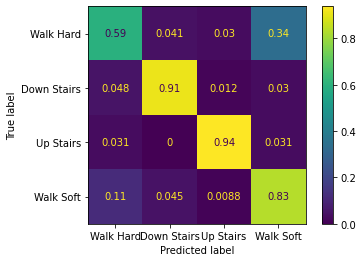

In [14]:
yTrainHat1 = M1.predict(xTrain)
yValHat1 = M1.predict(xVal)

print('Results for Validation:\n')
summaryPerf(yTrain,yTrainHat1,yVal,yValHat1)

In [15]:
# You should be able to get get a model with balanced accuracy greater than 0.75
assert metrics.balanced_accuracy_score(yVal,yValHat1)>0.75

#### 2-Layer MLP

In this case, we have a choice on the number of neurons for the hidden layer. Note that in this section, we will use the optimal number of epochs and weights found on the previous section.

In [16]:
# Defining the neural network architecture
class Net2(nn.Module):
  def __init__(self,noNeurons):
    super(Net2, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(INPUTSIZE,noNeurons),
        nn.ReLU(),
        nn.Linear(noNeurons,OUTPUTSIZE),
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

Defining and training the model with an arbitrary number of neurons.

In [17]:
# Setting the number of neurons. You can change this.
noNeurons = 4

In [18]:
if(not SUBMISSION):
    # Defining the Model
    model = Net2(noNeurons).to(DEVICE)
    M2 = NetWrapper(model,DEVICE,epochs_opt,weights_opt)

    # Displaying a summary
    fncs.summary(M2.model,(1,INPUTSIZE))

    # Training the model
    M2.fit(xTrain,yTrain)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              52
              ReLU-2                 [-1, 1, 4]               0
            Linear-3                 [-1, 1, 4]              20
              Net2-4                 [-1, 1, 4]               0
Total params: 72
Trainable params: 72
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------

[Epoch  1000 of 6000] loss: 0.592158
[Epoch  2000 of 6000] loss: 0.490613
[Epoch  3000 of 6000] loss: 0.438477
[Epoch  4000 of 6000] loss: 0.415792
[Epoch  5000 of 6000] loss: 0.405124
[Epoch  6000 of 6000] loss: 0.399738


Performance of predictions using the training and validation set.

Results for Validation:

Training:  Acc = 0.755
Non-Train: Acc = 0.738
Training:  BalAcc = 0.843
Non-Train: BalAcc = 0.843


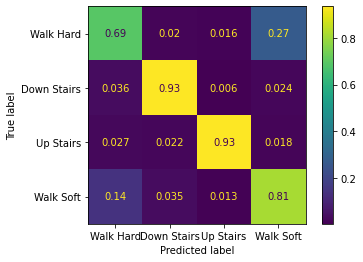

In [19]:
if(not SUBMISSION):
    yTrainHat = M2.predict(xTrain)
    yValHat = M2.predict(xVal)

    print('Results for Validation:\n')
    summaryPerf(yTrain,yTrainHat,yVal,yValHat)

In [20]:
unique_values = np.unique(yValHat)

# Print the unique values
print("Unique values in the array:", unique_values)

Unique values in the array: [0 1 2 3]


Performing a search for the number of neurons.

[Epoch  1000 of 6000] loss: 0.705011
[Epoch  2000 of 6000] loss: 0.624592
[Epoch  3000 of 6000] loss: 0.592003
[Epoch  4000 of 6000] loss: 0.558709
[Epoch  5000 of 6000] loss: 0.532024
[Epoch  6000 of 6000] loss: 0.524995
[Epoch  1000 of 6000] loss: 1.355576
[Epoch  2000 of 6000] loss: 0.940503
[Epoch  3000 of 6000] loss: 0.836193
[Epoch  4000 of 6000] loss: 0.800953
[Epoch  5000 of 6000] loss: 0.782627
[Epoch  6000 of 6000] loss: 0.771208
[Epoch  1000 of 6000] loss: 0.529448
[Epoch  2000 of 6000] loss: 0.476942
[Epoch  3000 of 6000] loss: 0.449993
[Epoch  4000 of 6000] loss: 0.427321
[Epoch  5000 of 6000] loss: 0.411099
[Epoch  6000 of 6000] loss: 0.392856
[Epoch  1000 of 6000] loss: 0.480721
[Epoch  2000 of 6000] loss: 0.420508
[Epoch  3000 of 6000] loss: 0.399838
[Epoch  4000 of 6000] loss: 0.383418
[Epoch  5000 of 6000] loss: 0.364583
[Epoch  6000 of 6000] loss: 0.354587


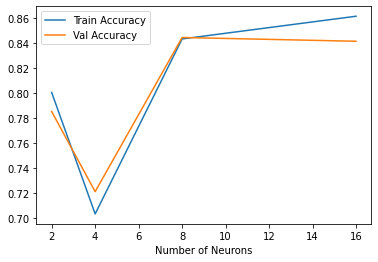

In [21]:
if(not SUBMISSION):
    # Lists containing the balanced accuracy for training and validation sets.
    accList_train = []
    accList_val = []

    # Setting a range of neurons 
    noNeuronsList = np.power(2,range(1,5))

    for noNeurons in noNeuronsList:
        # Defining and training the model
        model = Net2(noNeurons).to(DEVICE)
        M2 = NetWrapper(model,DEVICE,epochs_opt,weights_opt)
        M2.fit(xTrain,yTrain)

        # Computing the predictions
        yTrainHat = M2.predict(xTrain)
        yValHat = M2.predict(xVal)

        # Storing the accuracies
        accList_train.append(metrics.balanced_accuracy_score(yTrain,yTrainHat))
        accList_val.append(metrics.balanced_accuracy_score(yVal,yValHat))

    # Plotting the results
    plt.plot(noNeuronsList,accList_train)
    plt.plot(noNeuronsList,accList_val)
    plt.legend(['Train Accuracy','Val Accuracy'])
    plt.xlabel('Number of Neurons')
    plt.show()

In [22]:
# Initializing the number of neurons
noNeurons1_opt = 7



Defining and training the optimal model.

In [23]:
# Defining the Model
model = Net2(noNeurons1_opt).to(DEVICE)
M2 = NetWrapper(model,DEVICE,epochs_opt,weights_opt)

# Displaying a summary
fncs.summary(M2.model,(1,INPUTSIZE))

# Training the model
M2.fit(xTrain,yTrain)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 7]              91
              ReLU-2                 [-1, 1, 7]               0
            Linear-3                 [-1, 1, 4]              32
              Net2-4                 [-1, 1, 4]               0
Total params: 123
Trainable params: 123
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------

[Epoch  1000 of 6000] loss: 0.638389
[Epoch  2000 of 6000] loss: 0.491497
[Epoch  3000 of 6000] loss: 0.432856
[Epoch  4000 of 6000] loss: 0.407507
[Epoch  5000 of 6000] loss: 0.396588
[Epoch  6000 of 6000] loss: 0.388437


Performance on the training and validation sets.

Results for Validation:

Training:  Acc = 0.753
Non-Train: Acc = 0.750
Training:  BalAcc = 0.846
Non-Train: BalAcc = 0.847


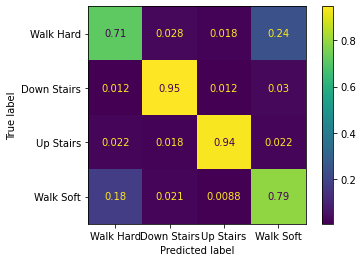

In [24]:
yTrainHat2 = M2.predict(xTrain)
yValHat2 = M2.predict(xVal)

print('Results for Validation:\n')
summaryPerf(yTrain,yTrainHat2,yVal,yValHat2)

In [25]:
# You should be able to get get a model with balanced accuracy greater than 0.82
assert metrics.balanced_accuracy_score(yVal,yValHat2)>0.82

#### 3-Layer MLP

When defining a 3-layer MLP, we have a choice for two of the neurons. We will set the first hidden layer to have the same number of layers as the optimal value found from the previous sections. We will also reuse the weights and number of epochs.

In this case, you will have to complete the neural network below to have an additional hidden layer followed by a ReLU activation.

In [26]:
# Defining the neural network architecture
class Net3(nn.Module):
  def __init__(self,noNeurons1,noNeurons2):
    super(Net3, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(INPUTSIZE, noNeurons1),
        nn.ReLU(),
        nn.Linear(noNeurons1, noNeurons2),
        nn.ReLU(),
        nn.Linear(noNeurons2, OUTPUTSIZE),
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [27]:
# Generating an arbitrary model so extract its layers
model = Net3(4,4).to(DEVICE)
layers = dict(model.named_modules())
layers = layers['linear_relu_stack']

# Checking that the types of layers are correct. If this fails is because you are not specifying
# the correct type of layers in your model.
assert isinstance(layers[0],torch.nn.Linear)
assert isinstance(layers[1],torch.nn.ReLU)
assert isinstance(layers[2],torch.nn.Linear)
assert isinstance(layers[3],torch.nn.ReLU)
assert isinstance(layers[4],torch.nn.Linear)

Performing a search for the number of neurons.

[Epoch  1000 of 6000] loss: 0.895762
[Epoch  2000 of 6000] loss: 0.737539
[Epoch  3000 of 6000] loss: 0.659906
[Epoch  4000 of 6000] loss: 0.628105
[Epoch  5000 of 6000] loss: 0.611024
[Epoch  6000 of 6000] loss: 0.601224
[Epoch  1000 of 6000] loss: 0.550336
[Epoch  2000 of 6000] loss: 0.400196
[Epoch  3000 of 6000] loss: 0.386522
[Epoch  4000 of 6000] loss: 0.381605
[Epoch  5000 of 6000] loss: 0.379126
[Epoch  6000 of 6000] loss: 0.377712
[Epoch  1000 of 6000] loss: 0.449806
[Epoch  2000 of 6000] loss: 0.396993
[Epoch  3000 of 6000] loss: 0.382901
[Epoch  4000 of 6000] loss: 0.376506
[Epoch  5000 of 6000] loss: 0.373224
[Epoch  6000 of 6000] loss: 0.371379
[Epoch  1000 of 6000] loss: 0.432337
[Epoch  2000 of 6000] loss: 0.390906
[Epoch  3000 of 6000] loss: 0.378100
[Epoch  4000 of 6000] loss: 0.370751
[Epoch  5000 of 6000] loss: 0.366851
[Epoch  6000 of 6000] loss: 0.364937


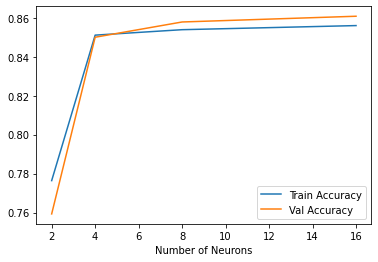

In [28]:
if(not SUBMISSION):
    # Lists containing the balanced accuracy for training and validation sets.
    accList_train = []
    accList_val = []

    # Setting a range of neurons 
    noNeuronsList = np.power(2,range(1,5))

    for noNeurons in noNeuronsList:
        # Defining and training the model
        model = Net3(noNeurons1_opt,noNeurons).to(DEVICE)
        M3 = NetWrapper(model,DEVICE,epochs_opt,weights_opt)
        M3.fit(xTrain,yTrain)

        # Computing the predictions
        yTrainHat = M3.predict(xTrain)
        yValHat = M3.predict(xVal)

        # Storing the accuracies
        accList_train.append(metrics.balanced_accuracy_score(yTrain,yTrainHat))
        accList_val.append(metrics.balanced_accuracy_score(yVal,yValHat))

    # Plotting the results
    plt.plot(noNeuronsList,accList_train)
    plt.plot(noNeuronsList,accList_val)
    plt.legend(['Train Accuracy','Val Accuracy'])
    plt.xlabel('Number of Neurons')
    plt.show()

In [29]:
# Initializing the number of neurons
noNeurons2_opt = 8




Defining and training the optimal model.

In [30]:
# Defining the Model
model = Net3(noNeurons1_opt,noNeurons2_opt).to(DEVICE)
M3 = NetWrapper(model,DEVICE,epochs_opt,weights_opt)

# Displaying a summary
fncs.summary(M3.model,(1,INPUTSIZE))

# Training the model
M3.fit(xTrain,yTrain)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 7]              91
              ReLU-2                 [-1, 1, 7]               0
            Linear-3                 [-1, 1, 8]              64
              ReLU-4                 [-1, 1, 8]               0
            Linear-5                 [-1, 1, 4]              36
              Net3-6                 [-1, 1, 4]               0
Total params: 191
Trainable params: 191
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------

[Epoch  1000 of 6000] loss: 0.438472
[Epoch  2000 of 6000] loss: 0.400282
[Epoch  3000 of 6000] loss: 0.385979
[Epoch  4000 of 6000] loss: 0.373447
[Epoch  5000 of 6000] loss: 0

Performance on the training and validation sets.

Results for Validation:

Training:  Acc = 0.773
Non-Train: Acc = 0.789
Training:  BalAcc = 0.855
Non-Train: BalAcc = 0.861


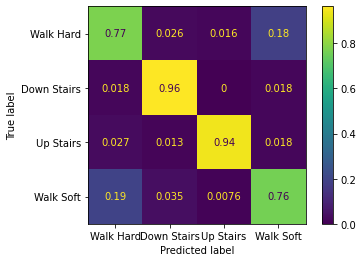

In [31]:
yTrainHat3 = M3.predict(xTrain)
yValHat3 = M3.predict(xVal)

print('Results for Validation:\n')
summaryPerf(yTrain,yTrainHat3,yVal,yValHat3)

In [32]:
# You should be able to get get a model with balanced accuracy greater than 0.84
assert metrics.balanced_accuracy_score(yVal,yValHat3)>0.84